In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [4]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise_data=True, 
                                                   batch_size=128, test_size=0.3, equiprobable_training_classes=True)

In [5]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [6]:
counts

array([144, 144, 144])

In [7]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [9]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1)

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

1.1015996932983398 33.7962962962963 23.91304347826087


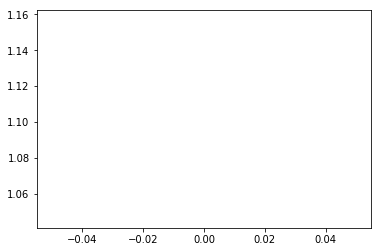

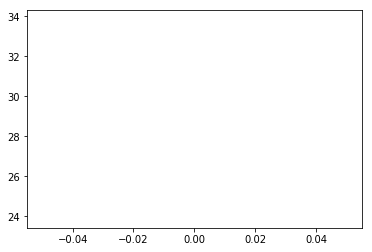

In [10]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [11]:
max(epoch_accuracies[1])

23.91304347826087

## Save model and scaler

In [12]:
torch.save(model.state_dict(), "models/passive_mass_model.pt")

In [13]:
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

In [14]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("models/passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [15]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [16]:
print(accuracy)

23.91304347826087


In [17]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

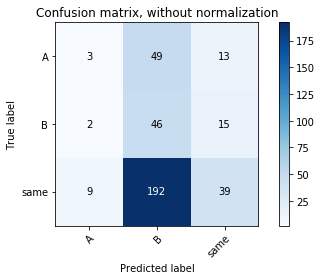

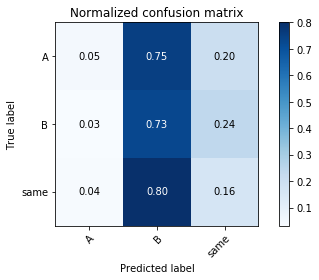

In [18]:
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [19]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, FORCE_CLASS_COLS, 
                                                   normalise_data=True, batch_size=128, test_size=0.3)

In [20]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [21]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3333333333333333


## Define model, loss and optimizer

In [22]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [23]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1)

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

1.1015823185443878 34.12698412698413 35.13513513513514


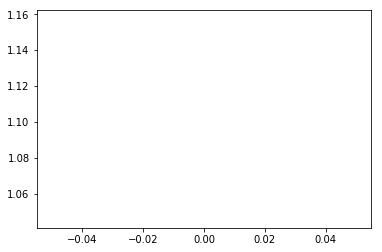

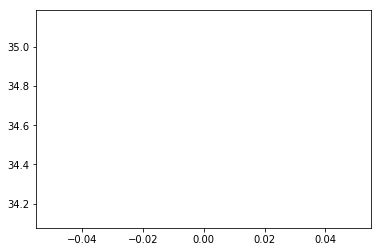

In [24]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [25]:
max(epoch_accuracies[1])

35.13513513513514

## Save model and scaler

In [27]:
torch.save(model.state_dict(), "models/passive_force_model.pt")

In [28]:
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Load model and evaluate

In [29]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
model.eval()
model = model.cuda()

In [30]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [31]:
print(accuracy)

35.13513513513514


In [32]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

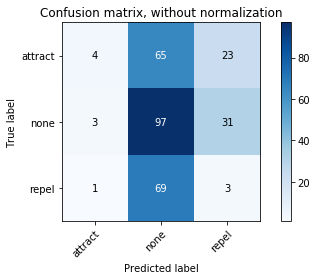

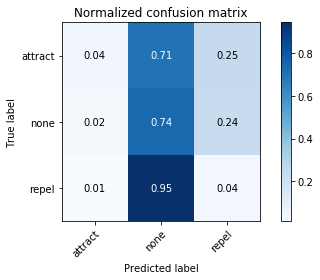

In [33]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)